In [1]:
import pandas as pd

In [2]:
task1_test_df = pd.read_parquet("/workspace/resources/tmp/task1_test.parquet")
task1_preds_df = pd.read_csv("/workspace/resources/tmp/osushineko_task1midterm_humob.csv.gz")

In [3]:
df = pd.concat([task1_test_df.query("d < 60"), task1_preds_df]).reset_index(drop=True)
df["time"] = (df["d"].astype(str).str.zfill(2) + df["t"].astype(str).str.zfill(2)).astype(int)

In [21]:
def assign_day_of_week(df):
    df["dayofweek"] = (df["d"] % 7).astype(int)
    df["weekend"] = df["dayofweek"].isin([6, 0])
    return df


def assign_t_labe(df):
    morning = {k: 0 for k in list(range(12, 36))}
    midnight = {k: 1 for k in list(range(36, 48)) + list(range(0, 12))}
    t_label_mapping = {**morning, **midnight}
    df["t_label"] = df["t"].map(t_label_mapping)
    return df

def assign_detailed_t_label(df):
    division = 48 // 12  # 48を12で割った値
    result_dict = {i: i // division for i in range(48)}
    df["detailed_t_label"] = df["t"].map(result_dict)
    return df
    

df = assign_day_of_week(df)
df = assign_t_labe(df)
df = assign_detailed_t_label(df)

keys = [
    "uid", 
    "dayofweek", 
    "detailed_t_label",
    ]
agg_df = df.query("d < 60").groupby(keys)[["x", "y"]].agg("mean").reset_index().rename(columns={"x":"agg_x", "y":"agg_y"})
if "agg_x" in df.columns:
    df.drop("agg_x", axis=1, inplace=True)
    df.drop("agg_y", axis=1, inplace=True)
df = pd.merge(df, agg_df, on=keys, how="left")
df.head()

,uid,d,t,x,y,time,dayofweek,weekend,t_label,color_condition,detailed_t_label,agg_x,agg_y
0,80000,0,15,138,66,15,0,True,0,False,3,120.000,59.333333
1,80000,0,16,135,75,16,0,True,0,False,4,116.625,76.375000
2,80000,0,17,126,74,17,0,True,0,False,4,116.625,76.375000
3,80000,0,18,77,116,18,0,True,0,False,4,116.625,76.375000
4,80000,0,19,64,109,19,0,True,0,False,4,116.625,76.375000


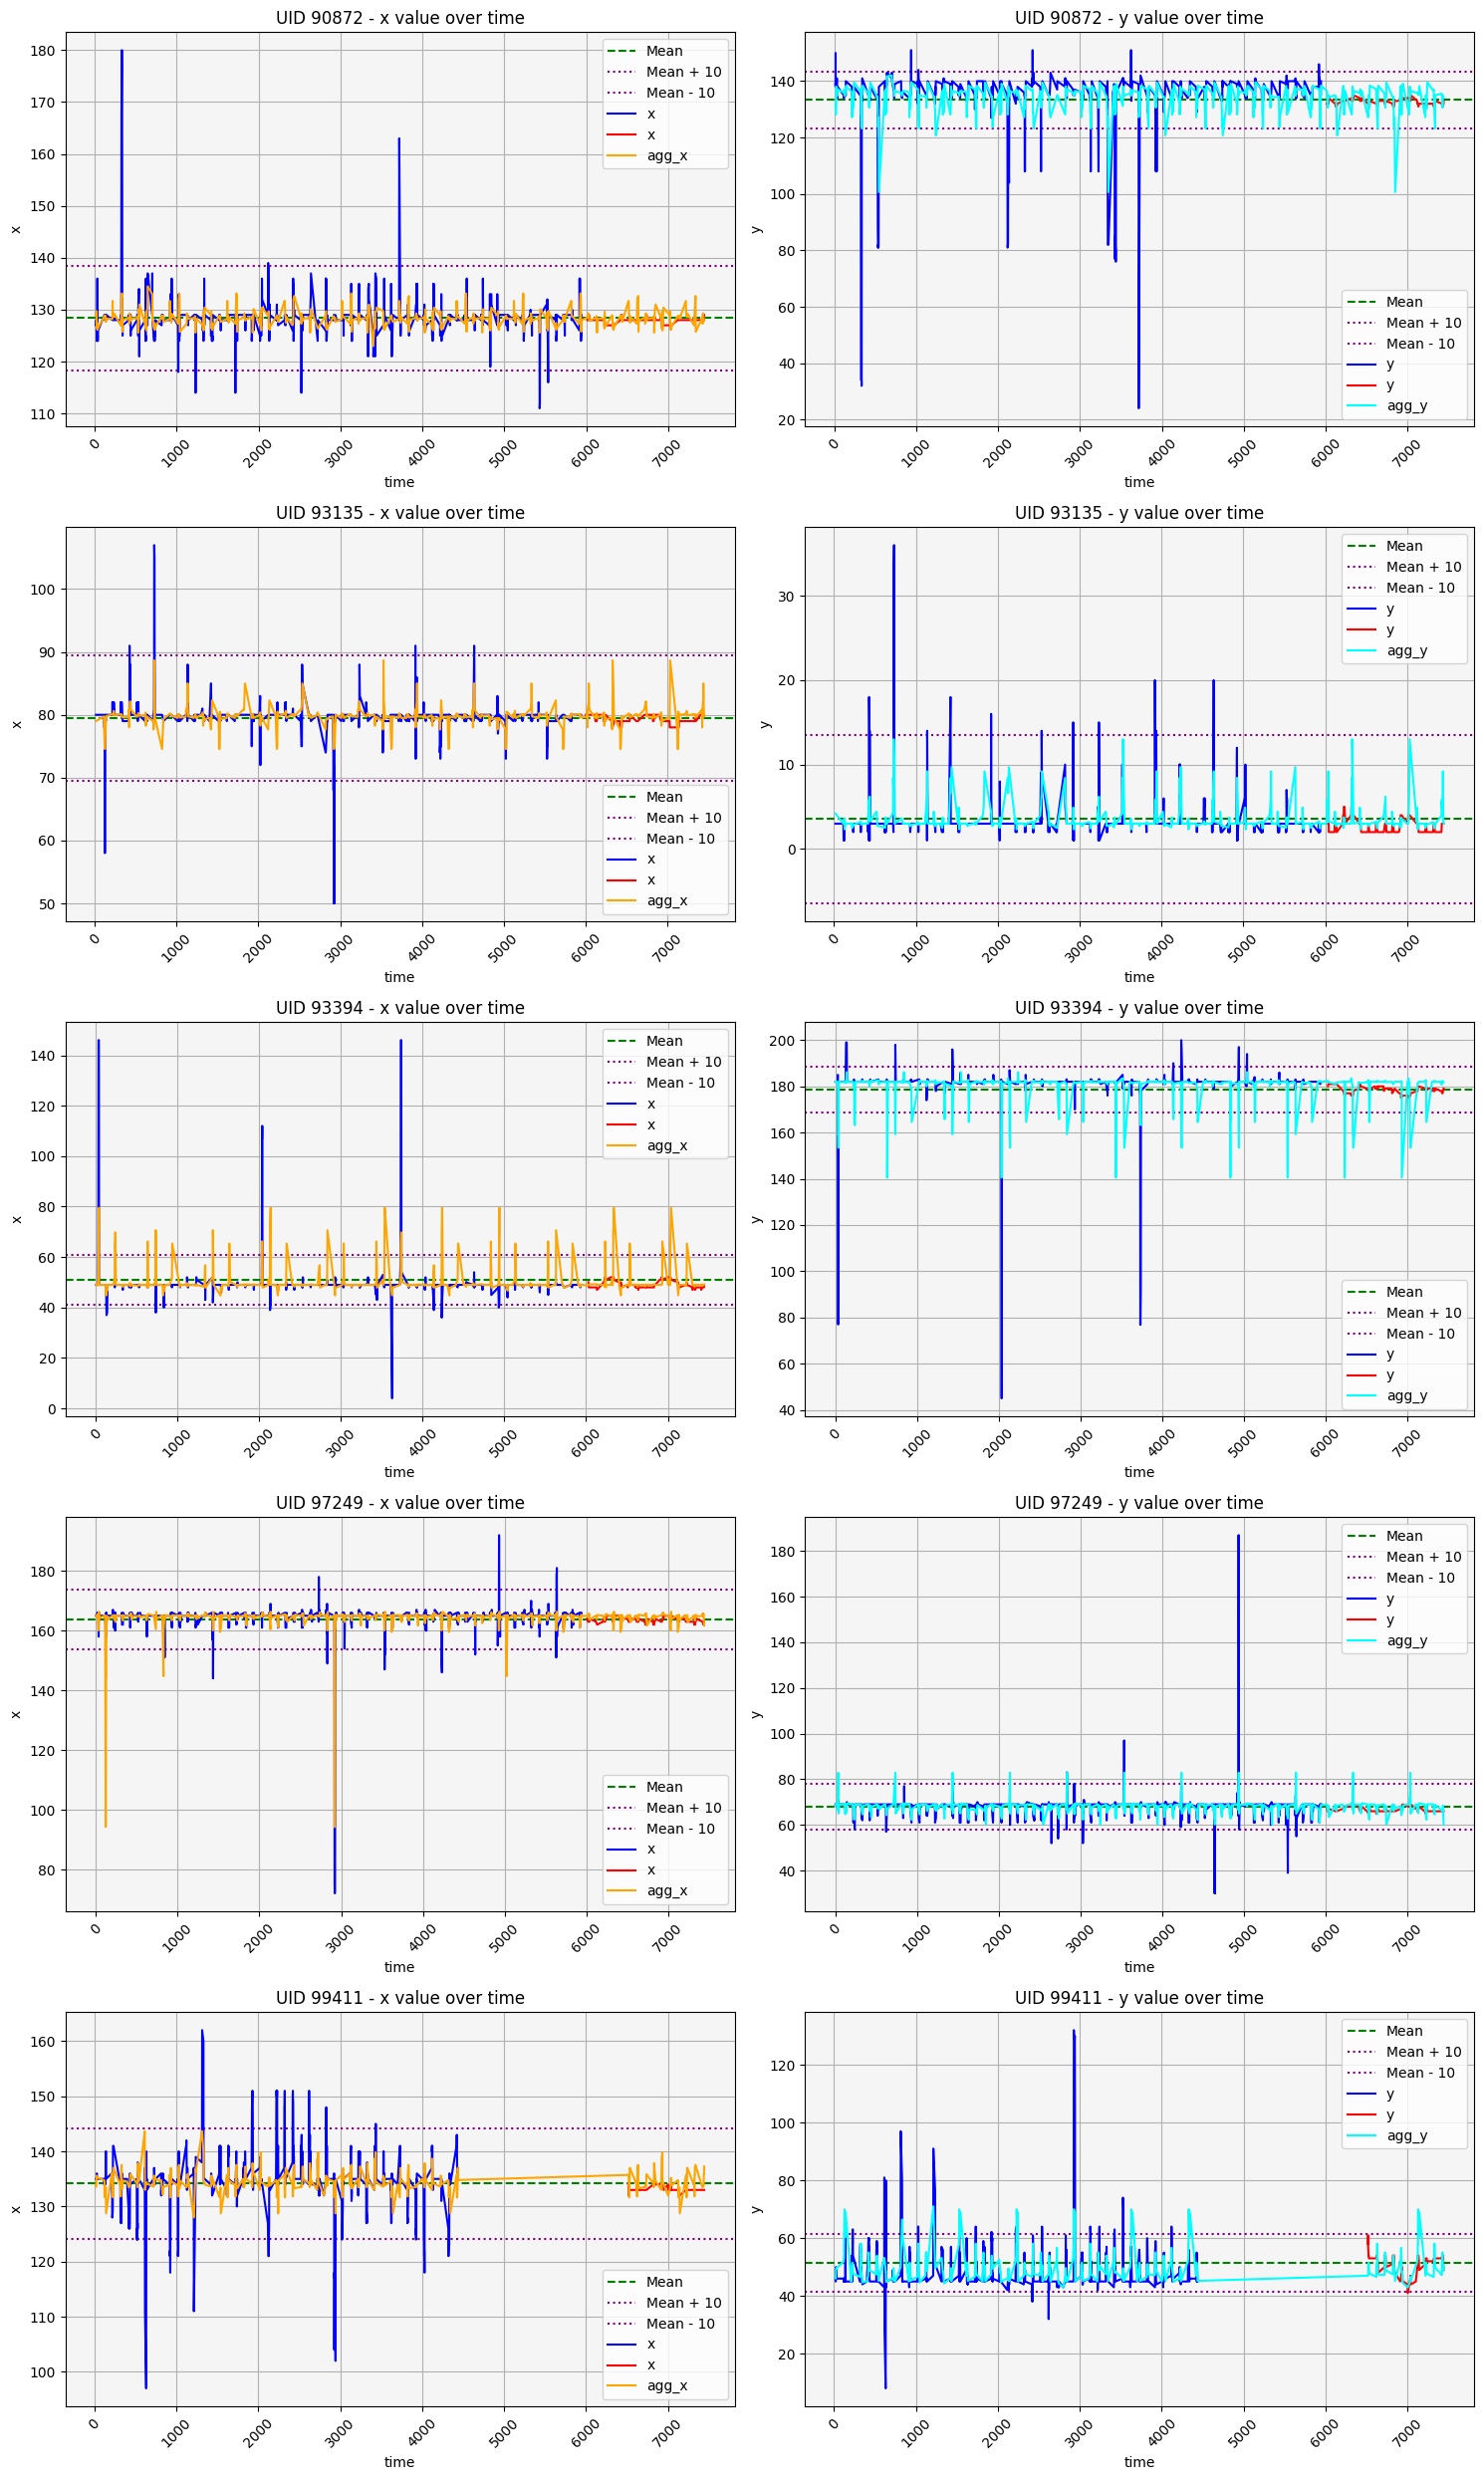

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_uid(df, uids):
    """
    df: DataFrame - 入力データ
    uids: list - グラフを出力したいuidのリスト
    """
        
    # d >= 60 の部分の色を変えるための列
    df['color_condition'] = df['d'] >= 60

    n_uids = len(uids)
    fig, axs = plt.subplots(n_uids, 2, figsize=(15, 5*n_uids))

    for i, uid in enumerate(uids):
        df_uid = df[df['uid'] == uid]

        for j, col in enumerate(['x', 'y']):
            mean_val = df_uid[col].mean()
            
            # 平均値の線
            axs[i, j].axhline(mean_val, color='green', linestyle='--', label='Mean')
            
            # 平均値±10の線
            axs[i, j].axhline(mean_val + 10, color='purple', linestyle=':', label='Mean + 10')
            axs[i, j].axhline(mean_val - 10, color='purple', linestyle=':', label='Mean - 10')
            
            sns.lineplot(x='time', y=col, hue='color_condition', data=df_uid, palette=["blue", "red"], ax=axs[i, j], legend=False, label=col)
            
            # agg_x または agg_y のデータを追加
            if col == 'x':
                sns.lineplot(x='time', y='agg_x', data=df_uid, color='orange', ax=axs[i, j], label='agg_x')
            else:
                sns.lineplot(x='time', y='agg_y', data=df_uid, color='cyan', ax=axs[i, j], label='agg_y')
            
            axs[i, j].set_title(f'UID {uid} - {col} value over time')
            axs[i, j].tick_params(axis='x', rotation=45)
            axs[i, j].grid(True)
            axs[i, j].set_facecolor("#f5f5f5")
            axs[i, j].legend()
    
    plt.tight_layout()
    plt.show()

uids = pd.Series(df["uid"].unique()).sample(5, random_state=None)
plot_uid(df, uids)
